# Analyses of ballistic movements and wheel states

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode

# from tslearn.barycenters import dtw_barycenter_averaging
# from tslearn.preprocessing import TimeSeriesResampler
# from tslearn.metrics import dtw_path

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get ballistic data and wheel states

In [5]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_wheel = str(results_path + 'mouse_movements_df01-08-2025')
wheel_df = pd.read_parquet(filename_wheel, engine='pyarrow')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/mouse_movements_df01-08-2025'

In [6]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')


In [87]:
new_states = states_file.copy()
new_states['new_bin'] = new_states['Bin'].round(1)
wheel_df['new_bin'] = wheel_df['Bin']/10.0

In [88]:
wheel_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '010': 0.0,
           '110': 1.0,
           '210': 2.0,
           '310': 3.0,
           '001': 0.0,
           '101': 1.0,
           '201': 2.0,
           '301': 3.0, 
           '011': 0.0,
           '111': 1.0,
           '211': 2.0,
           '311': 3.0,
           'nan': np.nan
           }
    
wheel_func = np.vectorize(wheel_mapping.get)

merged_df = new_states.merge(wheel_df[['new_bin', 'ballistic', 'mouse_name', 'session']], on=['new_bin', 'session', 'mouse_name'])
merged_df['wheel_states'] = wheel_func(merged_df['identifiable_states'])
merged_df.loc[merged_df['ballistic']==True, 'ballistic'] = 1
merged_df.loc[merged_df['ballistic']==False, 'ballistic'] = 0
merged_df.loc[merged_df['ballistic']==None, 'ballistic'] = 0

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_13264/666744968.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])[None,:],


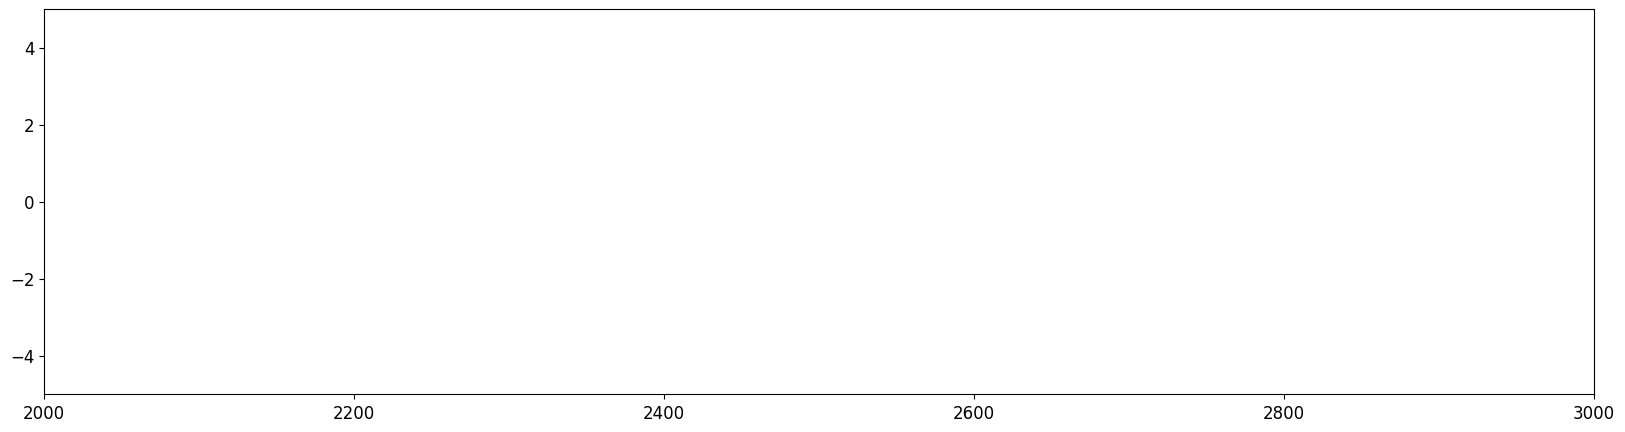

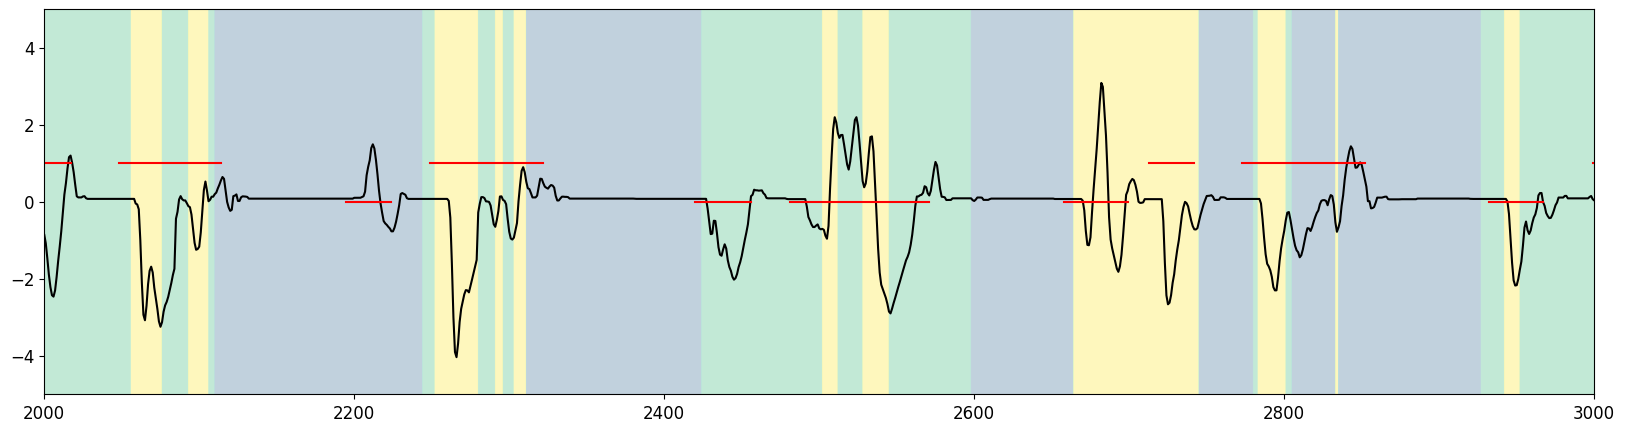

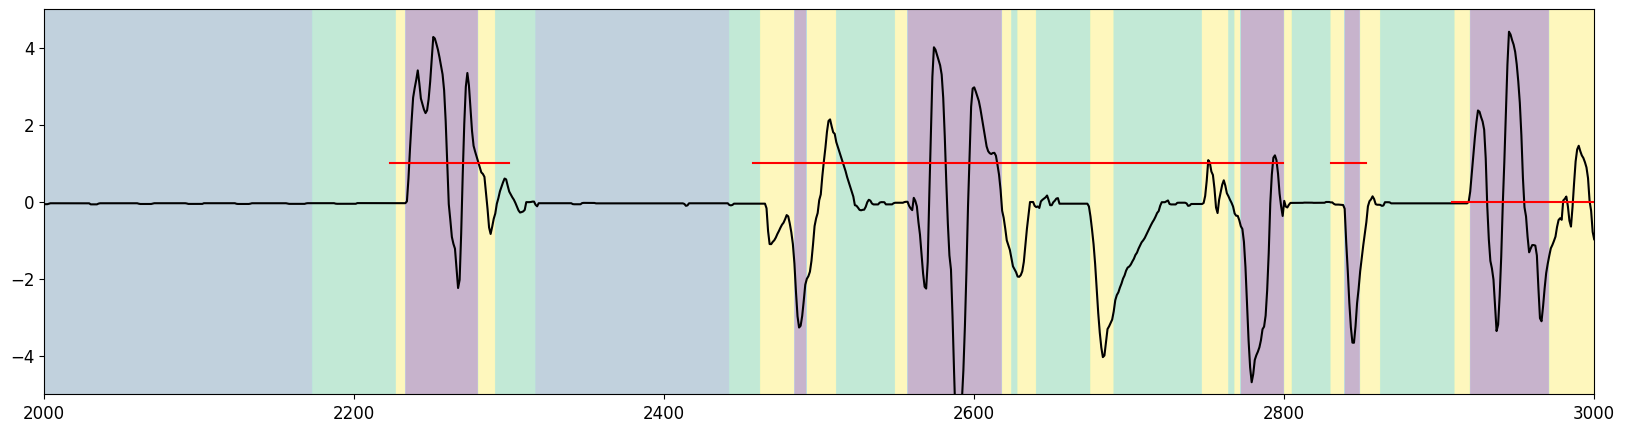

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_13264/666744968.py:13: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])[None,:],


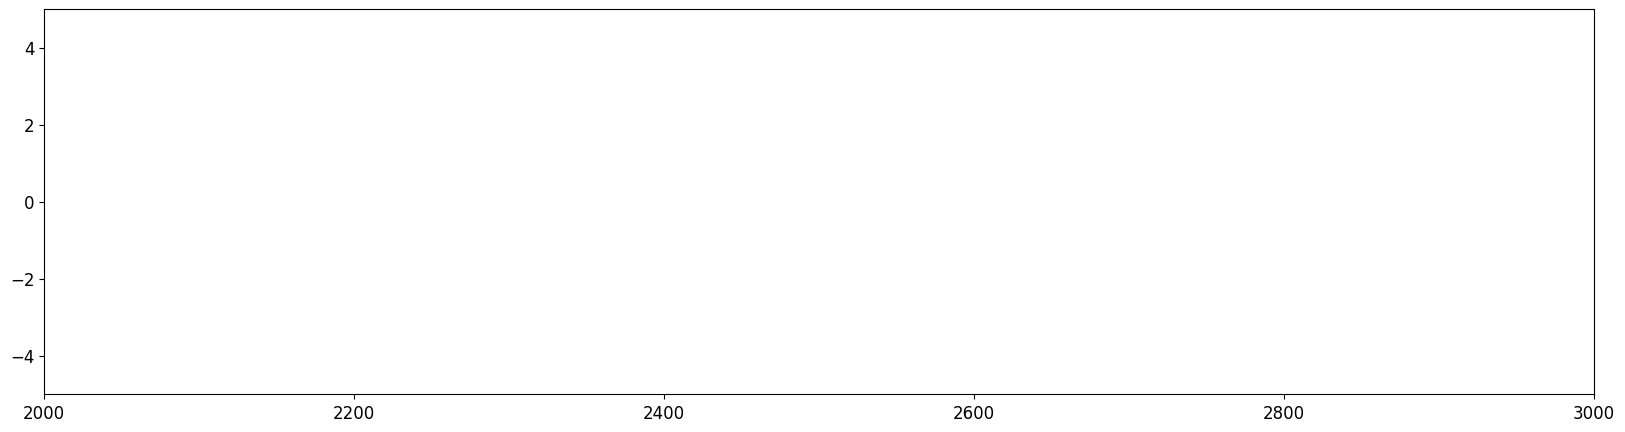

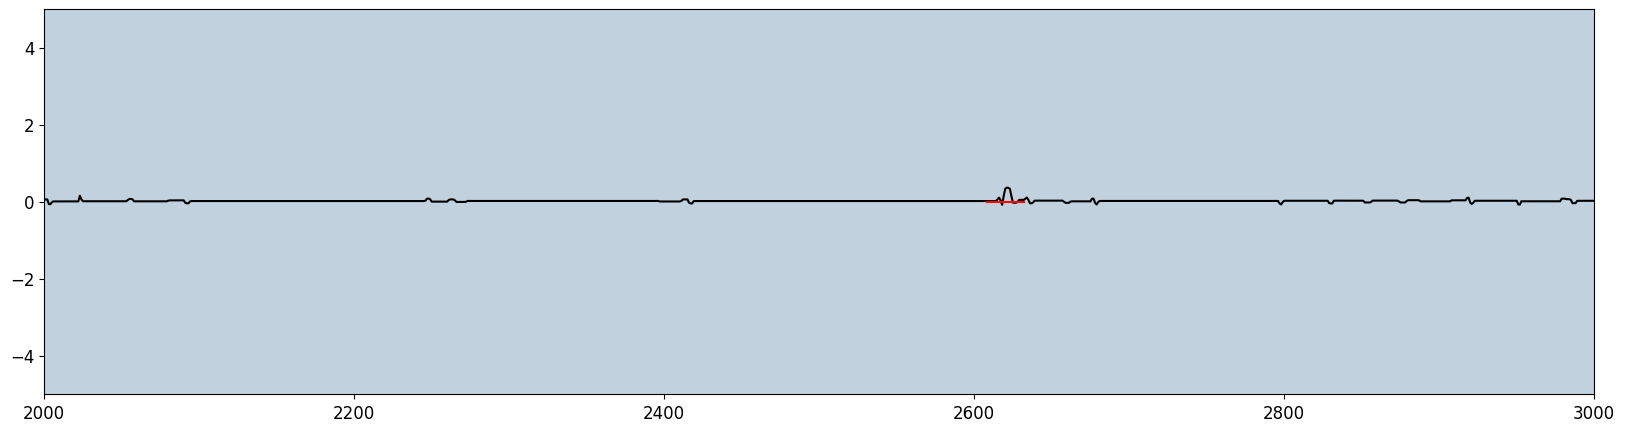

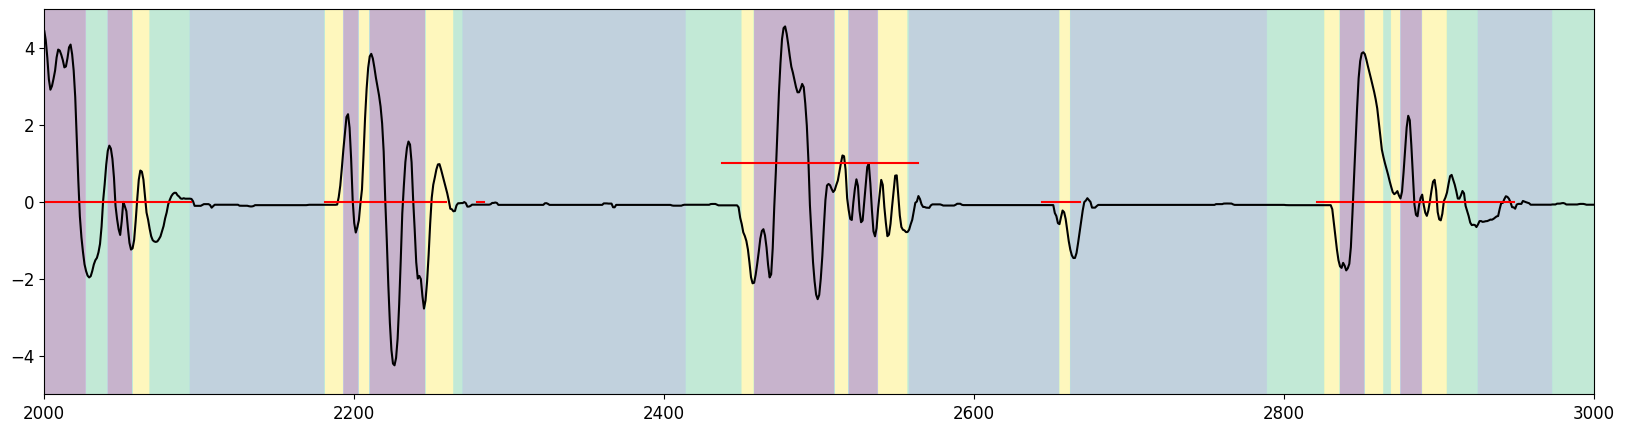

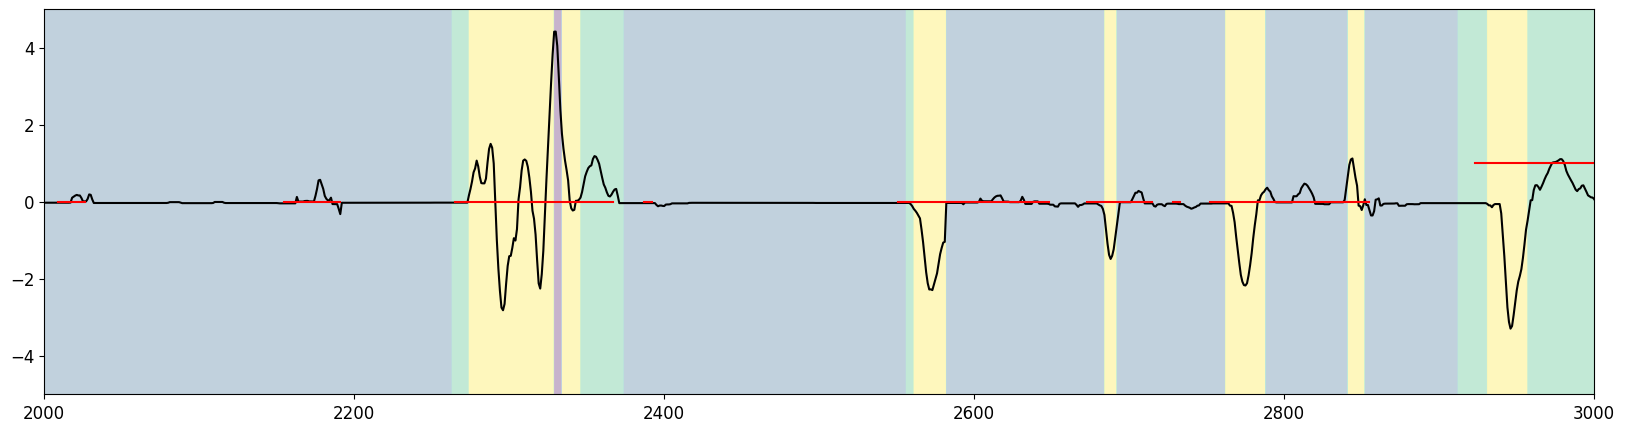

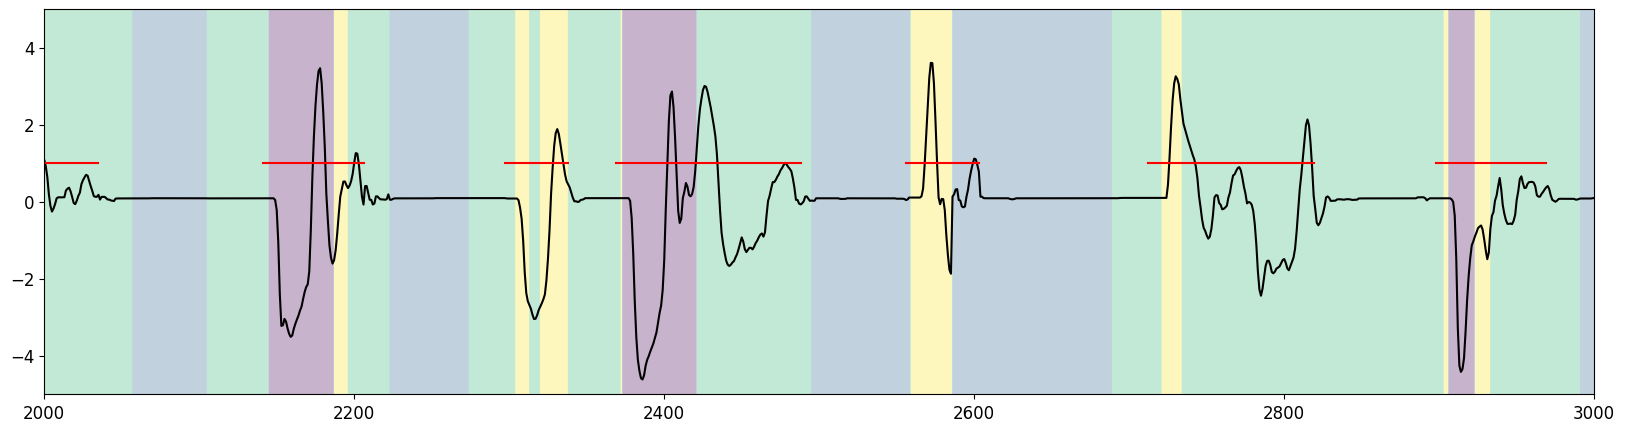

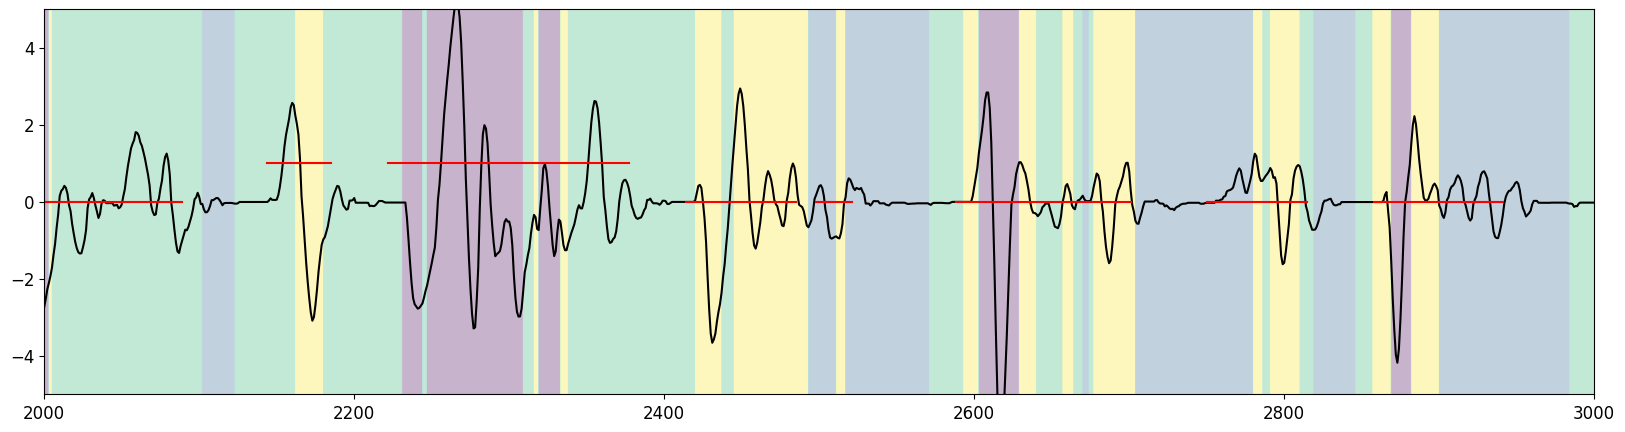

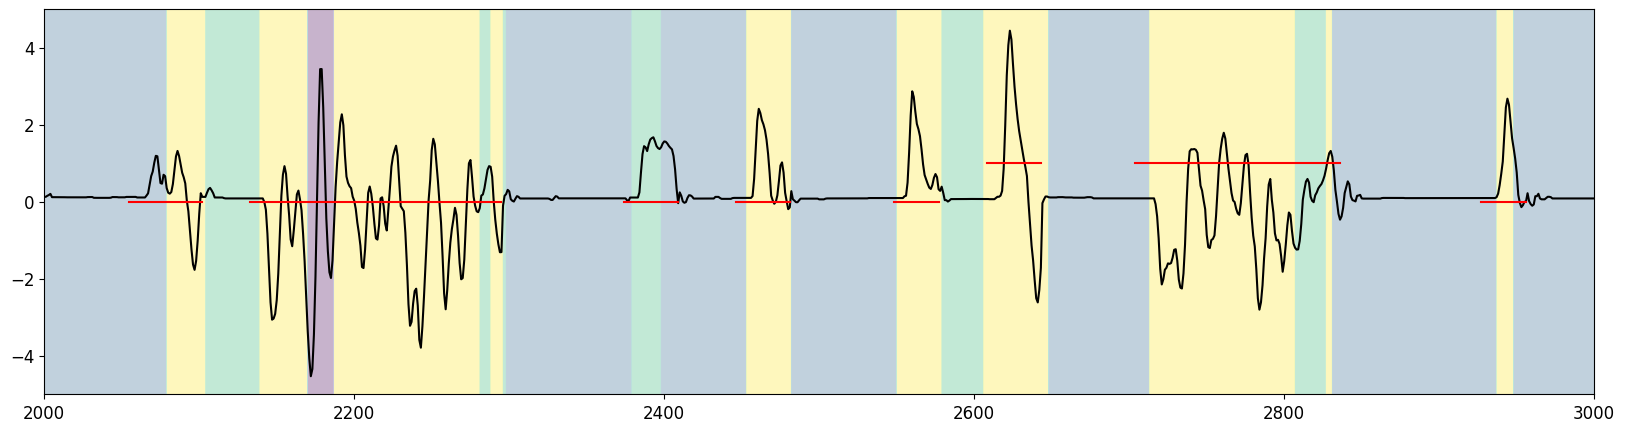

In [89]:
for m, mat in enumerate(sessions_to_process[:10]):

    mouse_name = mat[0]
    session = mat[1]

    mouse_session = merged_df.loc[(merged_df['session']==session)]


    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
    plt.rc('font', size=12)

    ax.plot(mouse_session.loc[mouse_session['new_bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
    ax.imshow(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])[None,:],
                extent=(0, len(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])), -10, 10),
                aspect="auto",
                cmap='viridis',
                alpha=0.3)
    ax.plot(mouse_session.loc[(mouse_session['new_bin']>=init) , 'ballistic'].reset_index(), color='red', label='Ballistic')

    init=2000
    plt.xlim([init, init+1000])
    plt.ylim([-5, 5])
    plt.show()


In [ ]:

    # # Plot raw trace over states       
    init = 500
    inter = 700
    wheel_over_wavelet_clusters(init, inter, empirical_data, plot_var, session_trials, vlines=False)

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_13264/2317277256.py:6: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])[None,:],


(-5.0, 5.0)

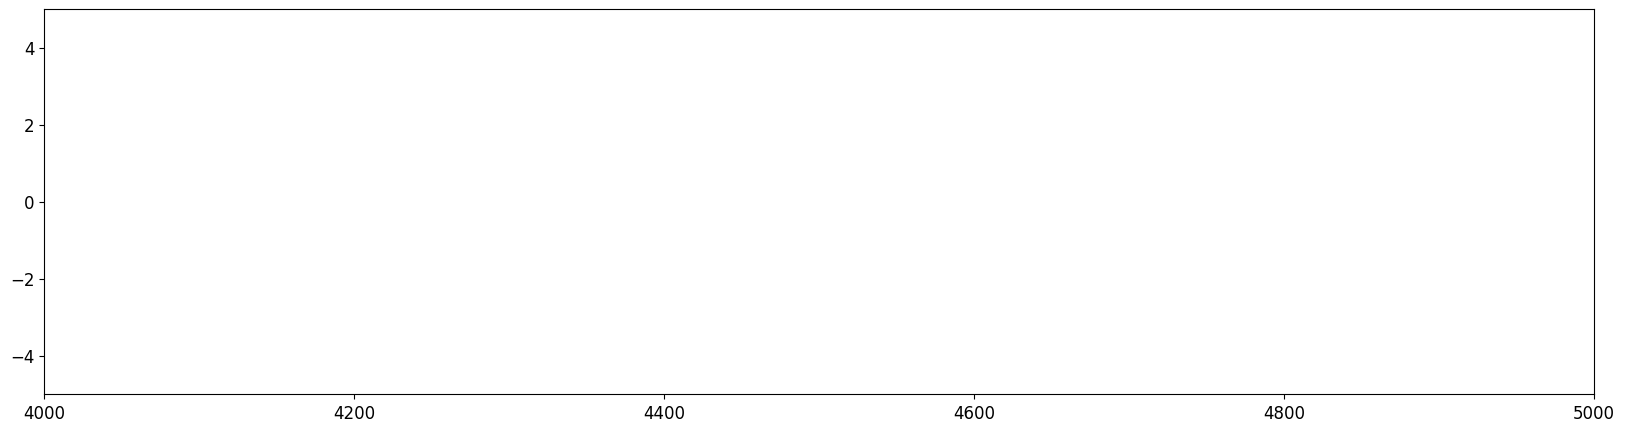

In [86]:
fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)

# ax.plot(data)
ax.plot(mouse_session.loc[mouse_session['new_bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
ax.imshow(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])[None,:],
            extent=(0, len(np.concatenate([mouse_session.loc[mouse_session['new_bin']>=init, 'wheel_states']])), -10, 10),
            aspect="auto",
            cmap='viridis',
            alpha=0.3)
ax.plot(mouse_session.loc[(mouse_session['new_bin']>=init) , 'ballistic'].reset_index(), color='red', label='Ballistic')

init=4000
plt.xlim([init, init+1000])
plt.ylim([-5, 5])